### Classify each frame with ResNet-18 CNN

In [1]:
import os
import torch
import numpy as np
import torchvision
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
nb_classes = 8
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, nb_classes)

i = 0
for params in resnet18.parameters():
    if i < 9:
        params.requires_grad = False
    i += 1

In [3]:
batch_size = 64
n_epochs = 10

is_cpu_available = torch.cuda.is_available()

optimizer = optim.Adam(resnet18.parameters(), lr=0.0001, weight_decay=0.0001)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.95, weight_decay=0.0001)
criteria = nn.CrossEntropyLoss()

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset/train', train_transforms)
val_dataset = ImageFolder('./dataset/val', val_transforms)
test_dataset = ImageFolder('./dataset/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

classes = ['badminton', 'bocce', 'croquet', 'polo', 'rock-climbing', 'rowing', 'sailing', 'snowboarding']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


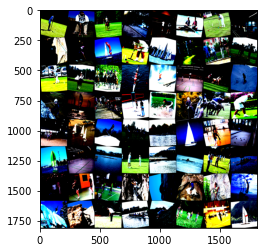

In [5]:
data_iter = iter(train_loader)
images, _ = data_iter.next()

grid_imgs = torchvision.utils.make_grid(images)
np_img = grid_imgs.numpy()
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()

In [6]:
resnet18.train()

if is_cpu_available:
    resnet18.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        resnet18.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = resnet18.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        resnet18.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = resnet18.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    resnet18.train()
    
writer.close()

Epoch: 0 - Train Loss: 0.9297499375210868 - Train Accuracy: 0.7411444187164307
Epoch: 0 - Val Loss: 0.2519338622689247 - Val Accuracy: 0.9015873074531555
Epoch: 1 - Train Loss: 0.1925945815940698 - Train Accuracy: 0.9482288956642151
Epoch: 1 - Val Loss: 0.13010783456265926 - Val Accuracy: 0.961904764175415
Epoch: 2 - Train Loss: 0.09597455192771223 - Train Accuracy: 0.9772933721542358
Epoch: 2 - Val Loss: 0.12346546230837703 - Val Accuracy: 0.9714285731315613
Epoch: 3 - Train Loss: 0.07119938938154115 - Train Accuracy: 0.9900091290473938
Epoch: 3 - Val Loss: 0.10555989011190832 - Val Accuracy: 0.9682539701461792
Epoch: 4 - Train Loss: 0.03870111641784509 - Train Accuracy: 0.995458722114563
Epoch: 4 - Val Loss: 0.09744788017123937 - Val Accuracy: 0.9746031761169434
Epoch: 5 - Train Loss: 0.028794549819495942 - Train Accuracy: 0.995458722114563
Epoch: 5 - Val Loss: 0.0771514524705708 - Val Accuracy: 0.9777777791023254
Epoch: 6 - Train Loss: 0.018287678352660604 - Train Accuracy: 1.0
Epoc

tensorboard --logdir runs

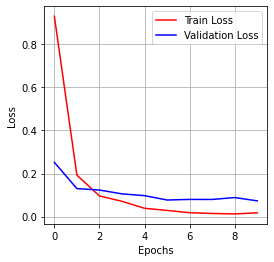

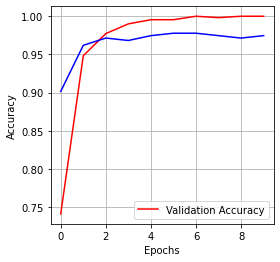

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.9693251252174377 


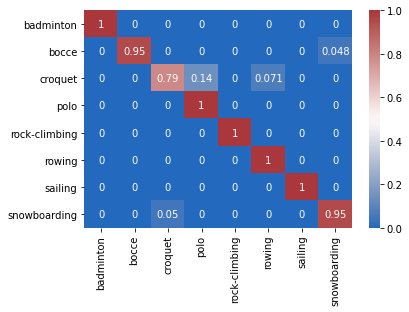

In [8]:
resnet18.eval()

targets = []
predicts = []

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = resnet18.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=classes, yticklabels=classes)